In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')

from sklearn.manifold import TSNE
from scipy import stats
import pickle

In [4]:
import class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader

series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# Loading data

In [5]:
# Loading the pairs
pairs_optics = pd.read_pickle('./data/pairs_optics.pickle', compression='infer')
pairs_hierarchical = pd.read_pickle('./data/pairs_hierarchical.pickle', compression='infer')
ticker_segment_dict = pd.read_pickle("./data/tickers.pickle", compression='infer')

# Loading the models
with open('./models/arima_optics.pkl', 'rb') as handle:
  arima_optics = pickle.load(handle)
with open('./models/arima_hierarchical.pkl', 'rb') as handle:
  arima_hierarchical = pickle.load(handle)
with open('./models/rnn_optics.pkl', 'rb') as handle:
  rnn_optics = pickle.load(handle)

# Trading Strategies

In [6]:
def trade_strategy(model, pairs, low_quantile, high_quantile, method='arima', val_or_test='val', profitable_pairs_indices=None, train_val_split='2021-01-03', train_test_split='2022-01-03'):
  """
  @param model: the ARIMA or RNN model which contains the training, validation and test data for each pair
  @param pairs: the OPTICS or hierarchical pairs
  @param low_quantile: the lower quantile of the negative changes in the spread to serve as the short entry threshold
  @param high_quantile: the higher quantile of the positive changes in the spread to serve as the long entry threshold
  @param method: ARIMA or RNN or SMR
  @param val_or_test: VAL or TEST
  @param profitable_pairs_indices: indices of profitable pairs if running the test set
  @param train_val_split: the training-validation split used for the validation set
  @param train_test_split: the training-test split used for the test set
  """

  # Declare summaries and performance measures
  cum_returns, sharpe_ratios = list(), list()
  balance_summaries, summaries = list(), list()

  indices = profitable_pairs_indices if profitable_pairs_indices is not None else range(len(pairs))
  
  if method.lower() != 'smr':
    for i in indices:

      if val_or_test.lower() == 'val':
        predictions = model['arima_predictions_val'][i] if method.lower() == 'arima' else model[i]['predictions_val']
        spread_train = pairs[i][2]['spread'][:train_val_split]
        spread_val_or_test = pairs[i][2]['spread'][train_val_split:]
        X = pairs[i][2]['X_train'][train_val_split:]
        Y = pairs[i][2]['Y_train'][train_val_split:]
      else:
        X = pairs[i][2]['X_test']
        Y = pairs[i][2]['Y_test']
        predictions = model['arima_predictions_test'][i] if method.lower() == 'arima' else model[i]['predictions_test']
        spread_train = pairs[i][2]['spread'][:train_test_split]
        spread_val_or_test = Y - pairs[i][2]['coint_coef'] * X
        if method.lower() == 'rnn':
          spread_val_or_test = spread_val_or_test[-len(predictions):]

      daily_return, cum_return, summary, balance_summary = forecasting_trader.forecast_spread_trading(X=X,
                                                                                                      Y=Y,
                                                                                                      spread_train=spread_train,
                                                                                                      spread_test=spread_val_or_test,
                                                                                                      beta=pairs[i][2]['coint_coef'],
                                                                                                      predictions=predictions,
                                                                                                      lag=1,
                                                                                                      low_quantile=low_quantile,
                                                                                                      high_quantile=high_quantile,
                                                                                                      multistep=0)
      if np.std(daily_return) != 0:
        sharpe_ratio = trader.calculate_sharpe_ratio(1, 252, daily_return)
      else:
          sharpe_ratio = 0

      cum_returns.append(cum_return[-1] * 100)
      sharpe_ratios.append(sharpe_ratio)
      summaries.append(summary)
      balance_summaries.append(balance_summary)
    
  else:
    results_without_costs, _, performance_standard = trader.apply_trading_strategy(pairs,
                                                                                   strategy='fixed_beta',
                                                                                   entry_multiplier=1,
                                                                                   exit_multiplier=0,
                                                                                   test_mode=False if val_or_test.lower() == 'val' else True,
                                                                                   train_val_split=train_val_split if val_or_test.lower() == 'val' else train_test_split)
    return results_without_costs, performance_standard

  return cum_returns, sharpe_ratios, summaries, balance_summaries

## OPTICS with ARIMA

### Validation Set

Annual ROI: 4.238784283375785%
50.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  7.110559307519931
Autocorrelation:  0.11130269998714037
Daily Sharpe Ratio 0.43574732696176743
Total number of trades:  1074
Positive trades:  815
Negative trades:  259
Total Drawdown Days: 56 days
Max DD period: 3 days
Maximum drawdown of portfolio: -0.12%




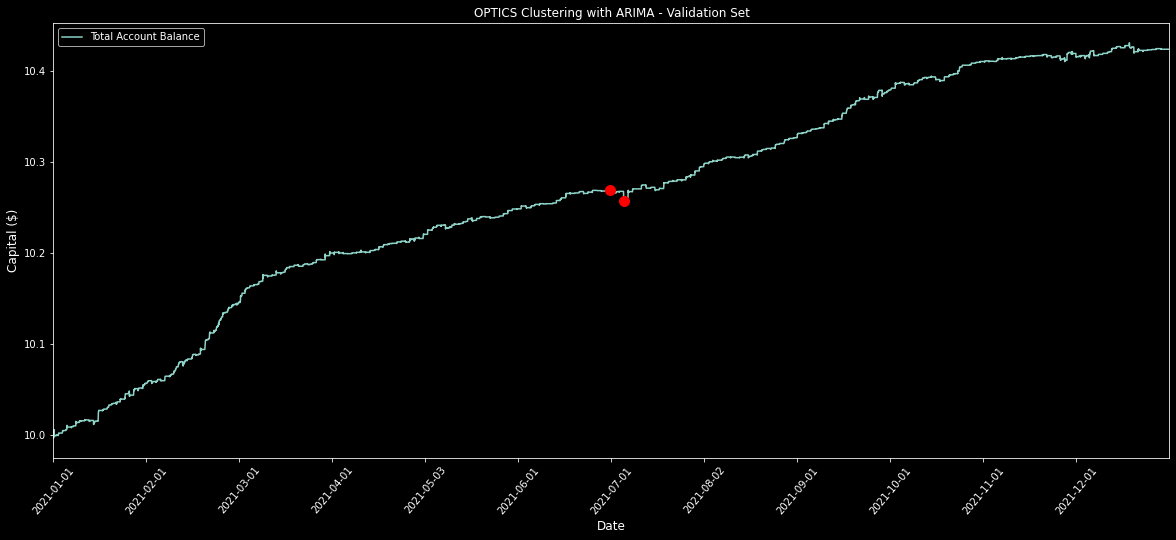

In [7]:
train_val_split = '2021-01-03'
cum_returns_optics_arima_val, sharpe_ratios_optics_arima_val, summaries_optics_arima_val, balance_summaries_optics_arima_val = trade_strategy(model=arima_optics,
                                                                                                                                              pairs=pairs_optics,
                                                                                                                                              low_quantile=0.2,
                                                                                                                                              high_quantile=0.8,
                                                                                                                                              method='ARIMA',
                                                                                                                                              val_or_test='VAL',
                                                                                                                                              train_val_split=train_val_split)

# Performance Measures
performance_optics_arima_val = [(summaries_optics_arima_val[i], balance_summaries_optics_arima_val[i]) for i in range(len(pairs_optics))]
results_optics_arima_val, pairs_summary_optics_arima_val = trader.summarize_results(sharpe_ratios_optics_arima_val,
                                                                      cum_returns_optics_arima_val,
                                                                      performance_optics_arima_val,
                                                                      pairs_optics,
                                                                      ticker_segment_dict,
                                                                      n_years=1,
                                                                      plot_title='OPTICS Clustering with ARIMA - Validation Set')

### Test Set

Annual ROI: 22.960791611371832%
100.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  9.071303071671785
Autocorrelation:  0.014511591111688942
Daily Sharpe Ratio 0.5105182114948457
Total number of trades:  1135
Positive trades:  892
Negative trades:  243
Total Drawdown Days: 46 days
Max DD period: 1 days
Maximum drawdown of portfolio: -0.45%




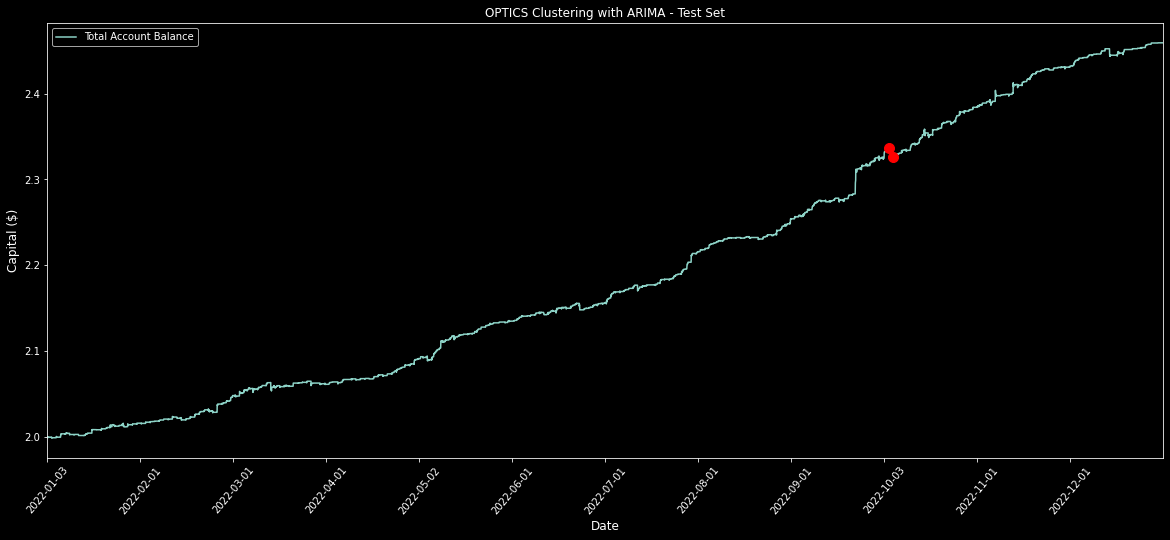

In [8]:
train_test_split = '2022-01-03'
profitable_pairs_indices_optics_arima = np.where(cum_returns_optics_arima_val > np.mean(cum_returns_optics_arima_val))[0]
cum_returns_optics_arima_test, sharpe_ratios_optics_arima_test, summaries_optics_arima_test, balance_summaries_optics_arima_test = trade_strategy(model=arima_optics,
                                                                                                                      pairs=pairs_optics,
                                                                                                                      profitable_pairs_indices=profitable_pairs_indices_optics_arima,
                                                                                                                      low_quantile=0.2,
                                                                                                                      high_quantile=0.8,
                                                                                                                      method='ARIMA',
                                                                                                                      val_or_test='TEST',
                                                                                                                      train_test_split=train_test_split)

# Performance Measures
performance_optics_arima_test = [(summaries_optics_arima_test[i], balance_summaries_optics_arima_test[i]) for i in range(len(profitable_pairs_indices_optics_arima))]
results_optics_arima_test, pairs_summary_optics_arima_test = trader.summarize_results(sharpe_ratios_optics_arima_test,
                                                                        cum_returns_optics_arima_test,
                                                                        performance_optics_arima_test,
                                                                        np.array(pairs_optics)[profitable_pairs_indices_optics_arima],
                                                                        ticker_segment_dict,
                                                                        n_years=1,
                                                                        plot_title='OPTICS Clustering with ARIMA - Test Set')

## OPTICS with RNN

### Validation Set

Annual ROI: 8.04968398899668%
80.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.461652548073652
Autocorrelation:  -0.07037364332878186
Daily Sharpe Ratio 0.14890915009541492
Total number of trades:  1685
Positive trades:  1212
Negative trades:  473
Total Drawdown Days: 104 days
Max DD period: 11 days
Maximum drawdown of portfolio: -1.43%




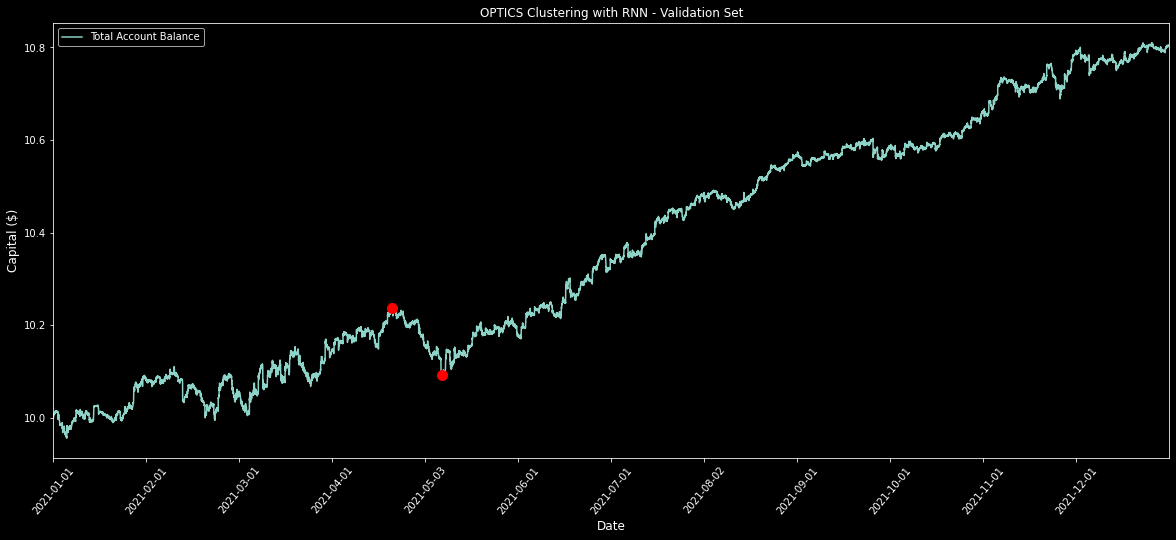

In [9]:
train_val_split = '2021-01-03'
cum_returns_optics_rnn_val, sharpe_ratios_optics_rnn_val, summaries_optics_rnn_val, balance_summaries_optics_rnn_val = trade_strategy(model=rnn_optics,
                                                                                                                                      pairs=pairs_optics,
                                                                                                                                      low_quantile=0.2,
                                                                                                                                      high_quantile=0.8,
                                                                                                                                      method='RNN',
                                                                                                                                      val_or_test='VAL',
                                                                                                                                      train_val_split=train_val_split)

# Performance Measures
performance_optics_rnn_val = [(summaries_optics_rnn_val[i], balance_summaries_optics_rnn_val[i]) for i in range(len(pairs_optics))]
results_optics_rnn_val, pairs_summary_optics_rnn_val = trader.summarize_results(sharpe_ratios_optics_rnn_val,
                                                                  cum_returns_optics_rnn_val,
                                                                  performance_optics_rnn_val,
                                                                  pairs_optics,
                                                                  ticker_segment_dict,
                                                                  n_years=1,
                                                                  plot_title='OPTICS Clustering with RNN - Validation Set')

### Test Set

Annual ROI: 24.836445387016724%
100.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.7662178402569957
Autocorrelation:  -0.0626358561907096
Daily Sharpe Ratio 0.15697788885083921
Total number of trades:  1165
Positive trades:  821
Negative trades:  344
Total Drawdown Days: 104 days
Max DD period: 49 days
Maximum drawdown of portfolio: -5.44%




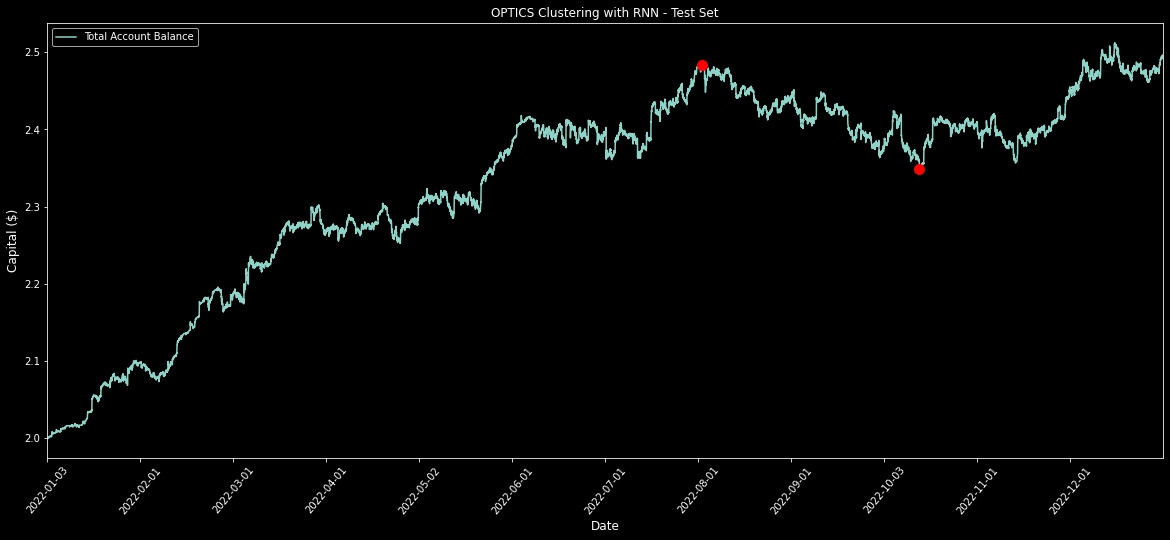

In [10]:
train_test_split = '2022-01-03'
profitable_pairs_indices_optics_rnn = np.where(cum_returns_optics_rnn_val > np.mean(cum_returns_optics_rnn_val))[0]
cum_returns_optics_rnn_test, sharpe_ratios_optics_rnn_test, summaries_optics_rnn_test, balance_summaries_optics_rnn_test = trade_strategy(model=rnn_optics,
                                                                                                              pairs=pairs_optics,
                                                                                                              profitable_pairs_indices=profitable_pairs_indices_optics_rnn,
                                                                                                              low_quantile=0.2,
                                                                                                              high_quantile=0.8,
                                                                                                              method='RNN',
                                                                                                              val_or_test='TEST',
                                                                                                              train_test_split=train_test_split)


# Performance Measures
performance_optics_rnn_test = [(summaries_optics_rnn_test[i], balance_summaries_optics_rnn_test[i]) for i in range(len(profitable_pairs_indices_optics_rnn))]
results_optics_rnn_test, pairs_summary_optics_rnn_test = trader.summarize_results(sharpe_ratios_optics_rnn_test,
                                                                                cum_returns_optics_rnn_test,
                                                                                performance_optics_rnn_test,
                                                                                np.array(pairs_optics)[profitable_pairs_indices_optics_rnn],
                                                                                ticker_segment_dict,
                                                                                n_years=1,
                                                                                plot_title='OPTICS Clustering with RNN - Test Set')

## OPTICS with Standard Mean Reversion

### Validation Set

Annual ROI: 13.040446019564932%
80.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.753645575786915
Autocorrelation:  -0.044186348189401335
Daily Sharpe Ratio 0.16328867160314162
Total number of trades:  65
Positive trades:  45
Negative trades:  20
Total Drawdown Days: 103 days
Max DD period: 18 days
Maximum drawdown of portfolio: -2.97%




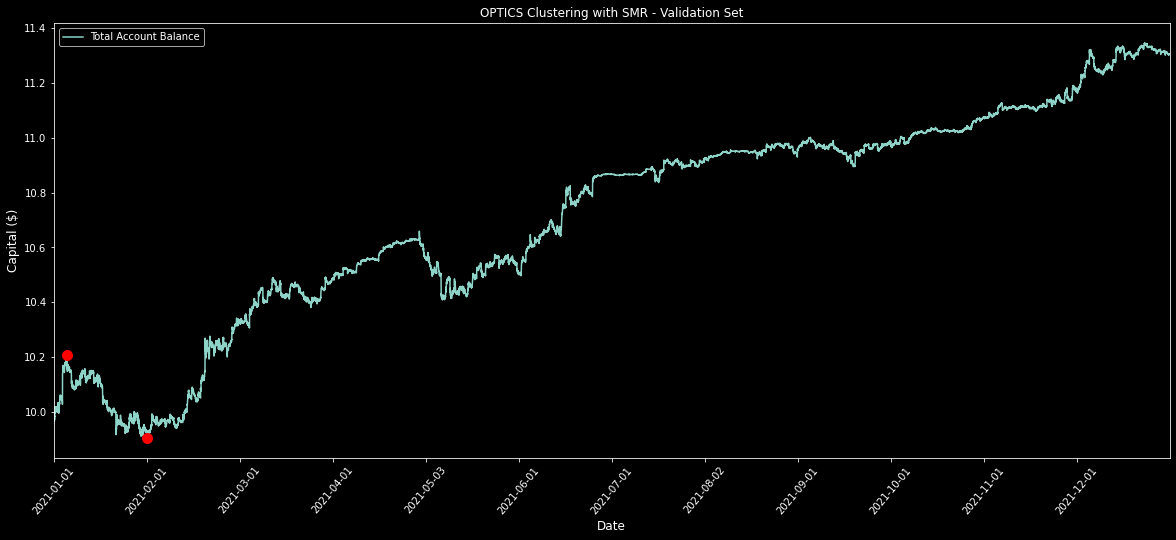

In [11]:
train_val_split = '2021-01-03'
returns_and_ratios_optics_smr_val, performance_optics_smr_val = trade_strategy(model=None,
                                                                               pairs=pairs_optics,
                                                                               low_quantile=None,
                                                                               high_quantile=None,
                                                                               method='SMR',
                                                                               val_or_test='VAL',
                                                                               train_val_split=train_val_split)

# Performance Measures
results_optics_smr_val, pairs_summary_optics_smr_val = trader.summarize_results(returns_and_ratios_optics_smr_val[0],
                                                                                returns_and_ratios_optics_smr_val[1],
                                                                                performance_optics_smr_val,
                                                                                pairs_optics,
                                                                                ticker_segment_dict,
                                                                                n_years=1,
                                                                                plot_title='OPTICS Clustering with SMR - Validation Set')

### Test Set

Annual ROI: 20.955336615133092%
100.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  1.8716362364408525
Autocorrelation:  -0.034174828632982816
Daily Sharpe Ratio 0.10929605654654549
Total number of trades:  20
Positive trades:  18
Negative trades:  2
Total Drawdown Days: 107 days
Max DD period: 23 days
Maximum drawdown of portfolio: -5.83%




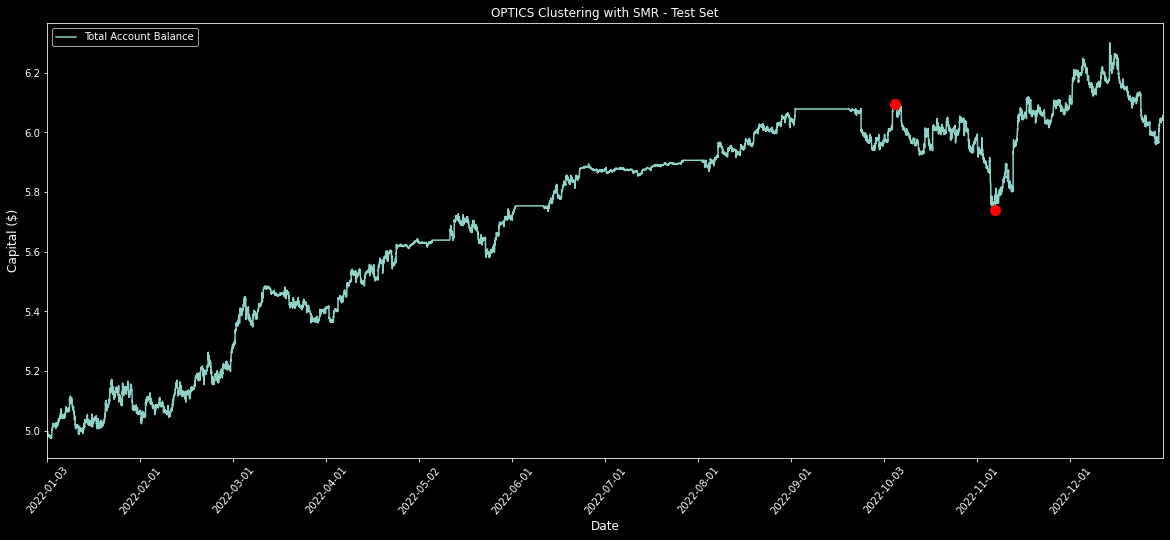

In [12]:
train_test_split = '2022-01-03'
profitable_pairs_indices_optics_smr = np.where(returns_and_ratios_optics_smr_val[1] > np.mean(returns_and_ratios_optics_smr_val[1]))[0]
returns_and_ratios_optics_smr_test, performance_optics_smr_test = trade_strategy(model=None,
                                                                                        pairs=np.array(pairs_optics)[profitable_pairs_indices_optics_smr],
                                                                                        low_quantile=None,
                                                                                        high_quantile=None,
                                                                                        method='SMR',
                                                                                        val_or_test='TEST',
                                                                                        train_test_split=train_test_split)

# Performance Measures
results_optics_optics_smr_test, pairs_summary_optics_optics_smr_test = trader.summarize_results(returns_and_ratios_optics_smr_test[0],
                                                                      returns_and_ratios_optics_smr_test[1],
                                                                      performance_optics_smr_test,
                                                                      np.array(pairs_optics)[profitable_pairs_indices_optics_smr],
                                                                      ticker_segment_dict,
                                                                      n_years=1,
                                                                      plot_title='OPTICS Clustering with SMR - Test Set')

## Hierarchical with ARIMA

### Validation Set

Annual ROI: 4.459351580347715%
40.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.840567419031321
Autocorrelation:  -0.010842566114669518
Daily Sharpe Ratio 0.23533660697923342
Total number of trades:  48933
Positive trades:  29821
Negative trades:  19112
Total Drawdown Days: 104 days
Max DD period: 24 days
Maximum drawdown of portfolio: -0.38%




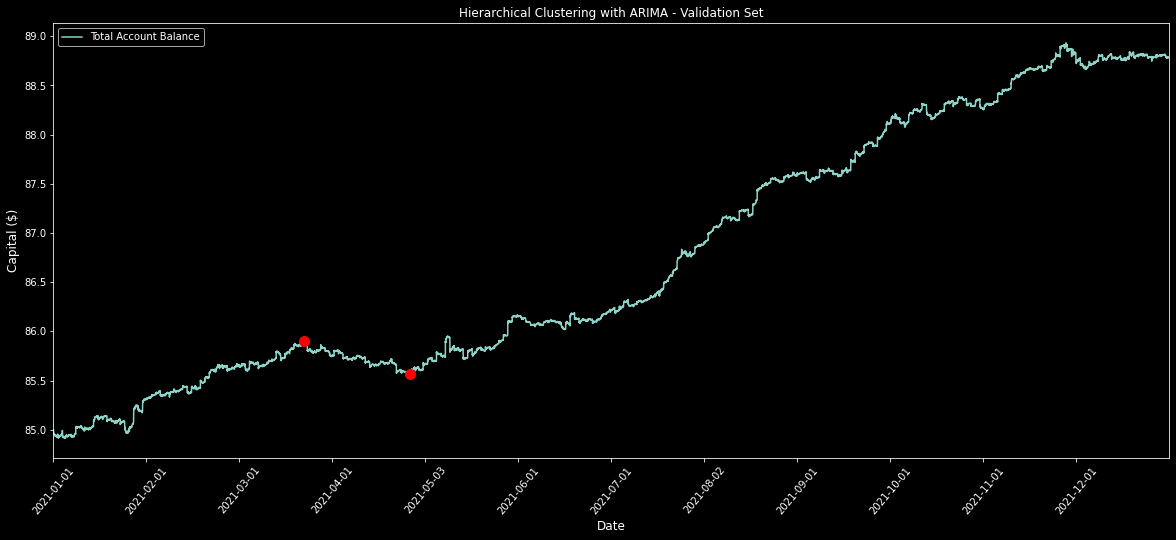

In [13]:
train_val_split = '2021-01-03'
cum_returns_hier_arima_val, sharpe_ratios_hier_arima_val, summaries_hier_arima_val, balance_summaries_hier_arima_val = trade_strategy(model=arima_hierarchical,
                                                                                                                                      pairs=pairs_hierarchical,
                                                                                                                                      low_quantile=0.1,
                                                                                                                                      high_quantile=0.9,
                                                                                                                                      method='ARIMA',
                                                                                                                                      val_or_test='VAL',
                                                                                                                                      train_val_split=train_val_split)

# Performance Measures
performance_hier_arima_val = [(summaries_hier_arima_val[i], balance_summaries_hier_arima_val[i]) for i in range(len(pairs_hierarchical))]
results_hier_arima_val, pairs_summary_hier_arima_val = trader.summarize_results(sharpe_ratios_hier_arima_val,
                                                                      cum_returns_hier_arima_val,
                                                                      performance_hier_arima_val,
                                                                      pairs_hierarchical,
                                                                      ticker_segment_dict,
                                                                      n_years=1,
                                                                      plot_title='Hierarchical Clustering with ARIMA - Validation Set')

### Test Set

Annual ROI: 36.58019797542824%
90.9090909090909 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.316919826900629
Autocorrelation:  -0.013340177872365485
Daily Sharpe Ratio 0.23225355639453038
Total number of trades:  40462
Positive trades:  24116
Negative trades:  16346
Total Drawdown Days: 85 days
Max DD period: 3 days
Maximum drawdown of portfolio: -5.13%




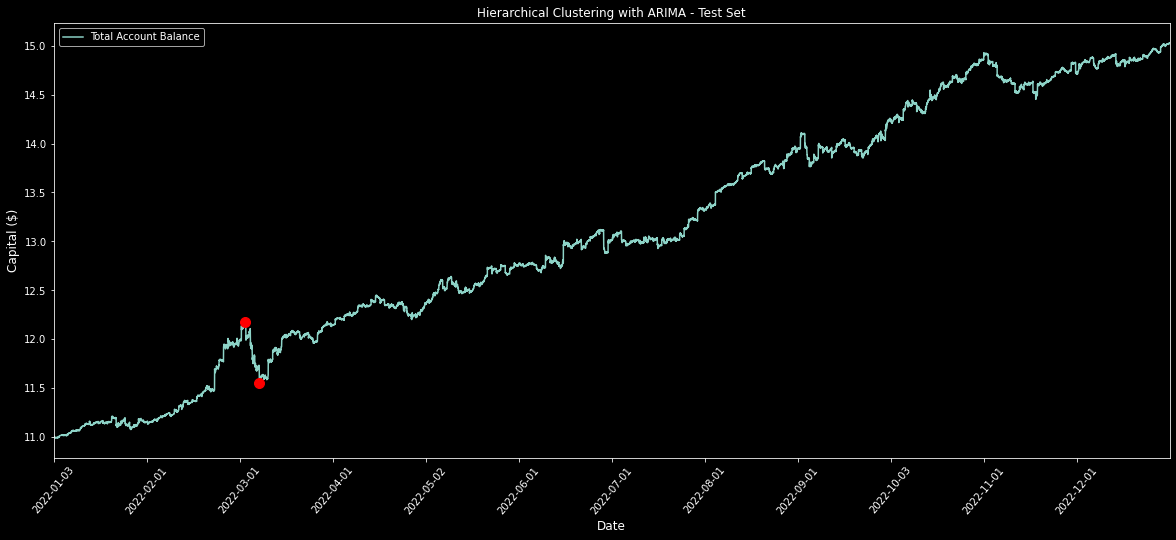

In [14]:
train_test_split = '2022-01-03'
profitable_pairs_indices_hier_arima = np.where(cum_returns_hier_arima_val > np.mean(cum_returns_hier_arima_val))[0]
cum_returns_hier_arima_test, sharpe_ratios_hier_arima_test, summaries_hier_arima_test, balance_summaries_hier_arima_test = trade_strategy(model=arima_hierarchical,
                                                                                                                                          pairs=pairs_hierarchical,
                                                                                                                                          profitable_pairs_indices=profitable_pairs_indices_hier_arima,
                                                                                                                                          low_quantile=0.1,
                                                                                                                                          high_quantile=0.9,
                                                                                                                                          method='ARIMA',
                                                                                                                                          val_or_test='TEST',
                                                                                                                                          train_test_split=train_test_split)

# Performance Measures
performance_hier_arima_test = [(summaries_hier_arima_test[i], balance_summaries_hier_arima_test[i]) for i in range(len(profitable_pairs_indices_hier_arima))]
results_hier_arima_test, pairs_summary_hier_arima_test = trader.summarize_results(sharpe_ratios_hier_arima_test,
                                                                                  cum_returns_hier_arima_test,
                                                                                  performance_hier_arima_test,
                                                                                  np.array(pairs_hierarchical)[profitable_pairs_indices_hier_arima],
                                                                                  ticker_segment_dict,
                                                                                  n_years=1,
                                                                                  plot_title='Hierarchical Clustering with ARIMA - Test Set')

## Hierarchical with Standard Mean Reversion

### Validation Set

Annual ROI: 17.56452872066978%
97.6470588235294 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.856647544772339
Autocorrelation:  0.004166161469072387
Daily Sharpe Ratio 0.2809850333972481
Total number of trades:  475
Positive trades:  392
Negative trades:  83
Total Drawdown Days: 98 days
Max DD period: 3 days
Maximum drawdown of portfolio: -1.06%




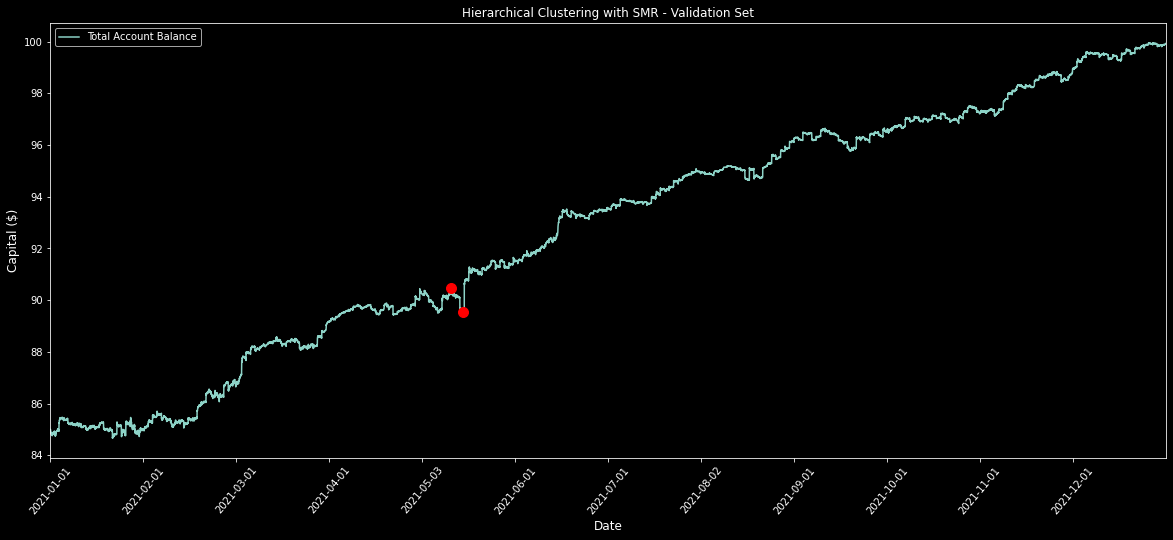

In [15]:
train_val_split = '2021-01-03'
returns_and_ratios_hier_smr_val, performance_hier_smr_val = trade_strategy(model=None,
                                                                           pairs=pairs_hierarchical,
                                                                           low_quantile=None,
                                                                           high_quantile=None,
                                                                           method='SMR',
                                                                           val_or_test='VAL',
                                                                           train_val_split=train_val_split)

# Performance Measures
results_optics_hier_smr_val, pairs_summary_optics_hier_smr_val = trader.summarize_results(returns_and_ratios_hier_smr_val[0],
                                                                                          returns_and_ratios_hier_smr_val[1],
                                                                                          performance_hier_smr_val,
                                                                                          pairs_hierarchical,
                                                                                          ticker_segment_dict,
                                                                                          n_years=1,
                                                                                          plot_title='Hierarchical Clustering with SMR - Validation Set')

### Test Set

Annual ROI: 21.687134382708262%
100.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.0933677123713945
Autocorrelation:  -0.02869349076030157
Daily Sharpe Ratio 0.17659830858878145
Total number of trades:  151
Positive trades:  126
Negative trades:  25
Total Drawdown Days: 103 days
Max DD period: 31 days
Maximum drawdown of portfolio: -3.38%




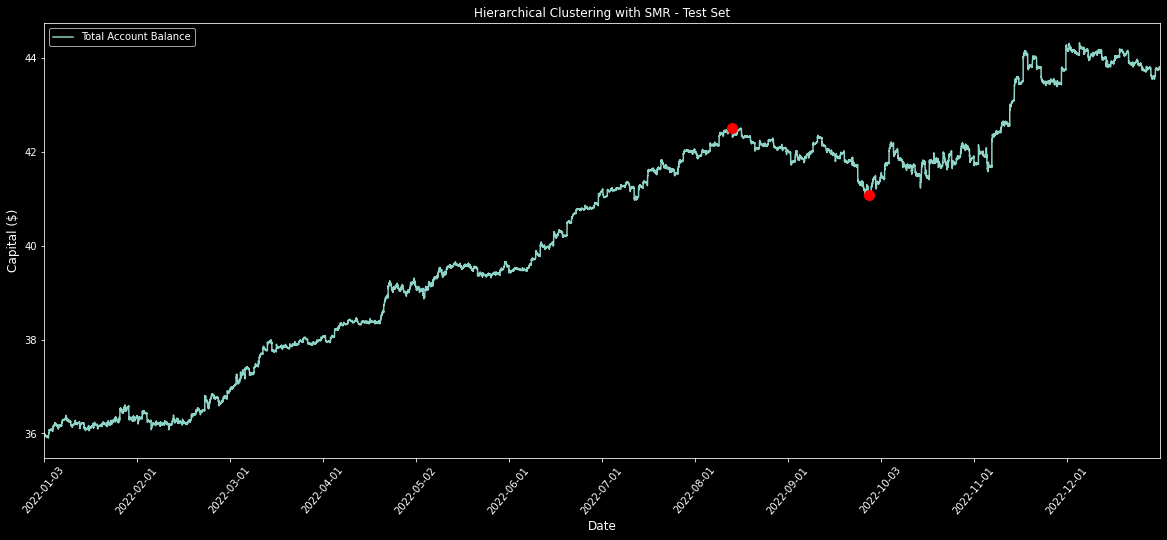

In [16]:
train_test_split = '2022-01-03'
profitable_pairs_indices_hier_smr = np.where(returns_and_ratios_hier_smr_val[1] > np.mean(returns_and_ratios_hier_smr_val[1]))[0]
returns_and_ratios_hier_smr_test, performance_hier_smr_test = trade_strategy(model=None,
                                                                             pairs=np.array(pairs_hierarchical)[profitable_pairs_indices_hier_smr],
                                                                             low_quantile=None,
                                                                             high_quantile=None,
                                                                             method='SMR',
                                                                             val_or_test='TEST',
                                                                             train_test_split=train_test_split)

# Performance Measures
results_hier_smr_test, pairs_summary_hier_smr_test = trader.summarize_results(returns_and_ratios_hier_smr_test[0],
                                                                      returns_and_ratios_hier_smr_test[1],
                                                                      performance_hier_smr_test,
                                                                      np.array(pairs_hierarchical)[profitable_pairs_indices_hier_smr],
                                                                      ticker_segment_dict,
                                                                      n_years=1,
                                                                      plot_title='Hierarchical Clustering with SMR - Test Set')

# Group by validation set

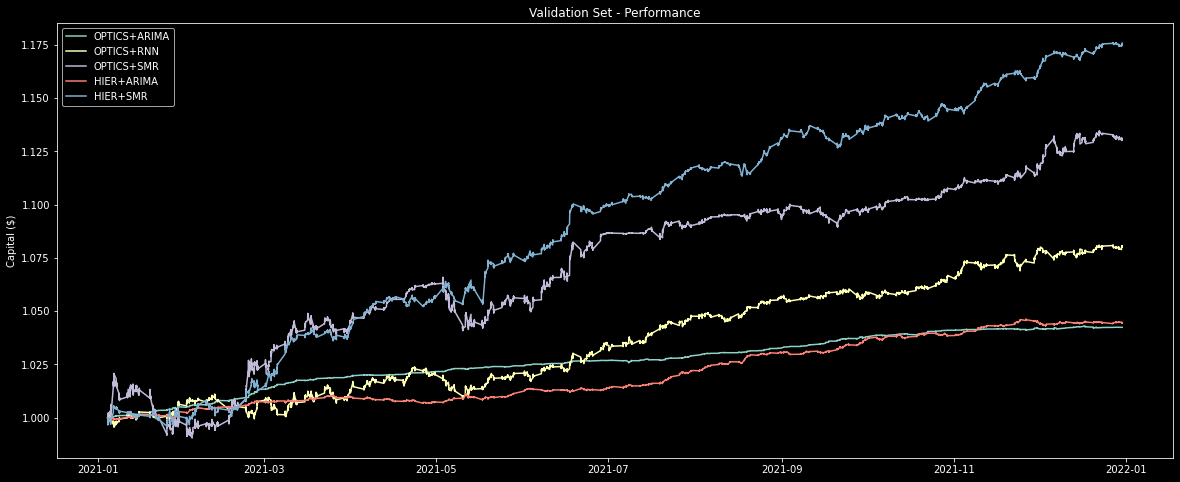

In [17]:
total_account_balance_optics_arima_val = performance_optics_arima_val[0][1]['account_balance']
total_account_balance_optics_rnn_val = performance_optics_rnn_val[0][1]['account_balance']
total_account_balance_optics_smr_val = performance_optics_smr_val[0][1]['account_balance']
total_account_balance_hier_arima_val = performance_hier_arima_val[0][1]['account_balance']
total_account_balance_hier_smr_val = performance_hier_smr_val[0][1]['account_balance']

# Calculate total balance for OPTICS pairs
for i in range(1, len(pairs_optics)):
  total_account_balance_optics_arima_val += performance_optics_arima_val[i][1]['account_balance']
  total_account_balance_optics_rnn_val += performance_optics_rnn_val[i][1]['account_balance']
  total_account_balance_optics_smr_val += performance_optics_smr_val[i][1]['account_balance']

# Calculate total balance for Hierarchical pairs
for i in range(1, len(pairs_hierarchical)):
  total_account_balance_hier_arima_val += performance_hier_arima_val[i][1]['account_balance']
  total_account_balance_hier_smr_val += performance_hier_smr_val[i][1]['account_balance']

total_account_balance_optics_arima_val /= total_account_balance_optics_arima_val[0]
total_account_balance_optics_rnn_val /= total_account_balance_optics_rnn_val[0]
total_account_balance_optics_smr_val /= total_account_balance_optics_smr_val[0]
total_account_balance_hier_arima_val /= total_account_balance_hier_arima_val[0]
total_account_balance_hier_smr_val /= total_account_balance_hier_smr_val[0]

plt.figure(figsize=(20, 8))
plt.plot(total_account_balance_optics_arima_val, label='OPTICS+ARIMA')
plt.plot(total_account_balance_optics_rnn_val, label='OPTICS+RNN')
plt.plot(total_account_balance_optics_smr_val, label='OPTICS+SMR')
plt.plot(total_account_balance_hier_arima_val, label='HIER+ARIMA')
plt.plot(total_account_balance_hier_smr_val, label='HIER+SMR')
plt.ylabel("Capital ($)")
plt.title("Validation Set - Performance")
plt.legend()
plt.show()

# Group by test set

In [18]:
# SP500 for comparison
sp500_df = pd.read_csv('./data/SP500_2022.csv', index_col='Date')
sp500_df['Adj. Close'] = sp500_df['Adj. Close'].apply(lambda x: x.replace(',', ''))
sp500_df['Adj. Close'] = pd.to_numeric(sp500_df['Adj. Close'])
sp500_df['Adj. Close'] /= sp500_df['Adj. Close'][0]
sp500_df.index = pd.to_datetime(sp500_df.index, dayfirst=True)
sp500_df

,Adj. Close
Date,
2022-01-03,1.000000
2022-01-04,0.999370
2022-01-05,0.979990
2022-01-06,0.979045
2022-01-07,0.975080
...,...
2022-12-22,0.796902
2022-12-23,0.801579
2022-12-27,0.798333


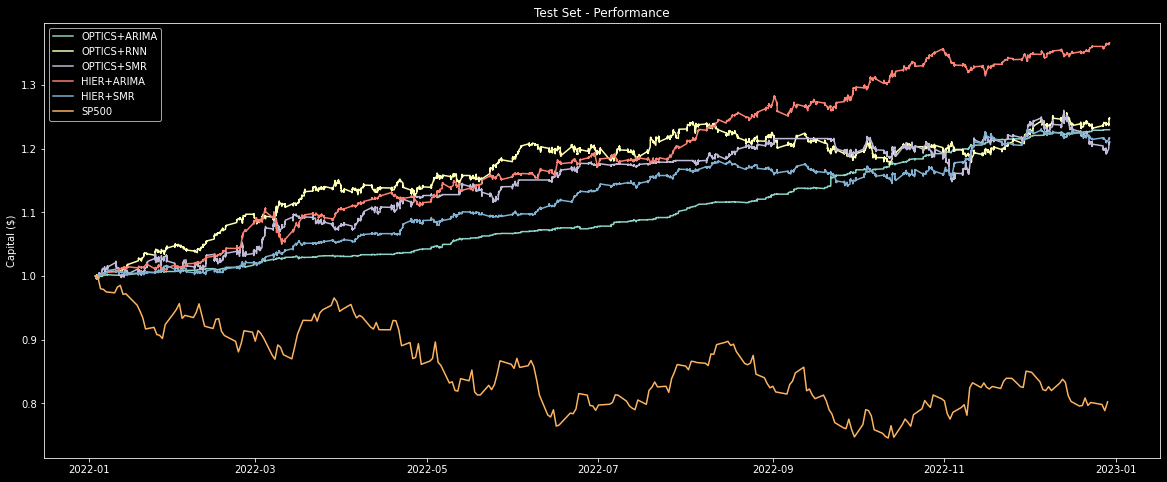

In [19]:
total_account_balance_optics_arima_test = performance_optics_arima_test[0][1]['account_balance']
total_account_balance_optics_rnn_test = performance_optics_rnn_test[0][1]['account_balance']
total_account_balance_optics_smr_test = performance_optics_smr_test[0][1]['account_balance']
total_account_balance_hier_arima_test = performance_hier_arima_test[0][1]['account_balance']
total_account_balance_hier_smr_test = performance_hier_smr_test[0][1]['account_balance']

# Calculate total balance for OPTICS pairs
for i in range(1, len(profitable_pairs_indices_optics_arima)):
  total_account_balance_optics_arima_test += performance_optics_arima_test[i][1]['account_balance']
for i in range(1, len(profitable_pairs_indices_optics_rnn)):
  total_account_balance_optics_rnn_test += performance_optics_rnn_test[i][1]['account_balance']
for i in range(1, len(profitable_pairs_indices_optics_smr)):
  total_account_balance_optics_smr_test += performance_optics_smr_test[i][1]['account_balance']

for i in range(1, len(profitable_pairs_indices_hier_arima)):
  total_account_balance_hier_arima_test += performance_hier_arima_test[i][1]['account_balance']
for i in range(1, len(profitable_pairs_indices_hier_smr)):
  total_account_balance_hier_smr_test += performance_hier_smr_test[i][1]['account_balance']

total_account_balance_optics_arima_test /= total_account_balance_optics_arima_test[0]
total_account_balance_optics_rnn_test /= total_account_balance_optics_rnn_test[0]
total_account_balance_optics_smr_test /= total_account_balance_optics_smr_test[0]
total_account_balance_hier_arima_test /= total_account_balance_hier_arima_test[0]
total_account_balance_hier_smr_test /= total_account_balance_hier_smr_test[0]

plt.figure(figsize=(20, 8))
plt.plot(total_account_balance_optics_arima_test, label='OPTICS+ARIMA')
plt.plot(total_account_balance_optics_rnn_test, label='OPTICS+RNN')
plt.plot(total_account_balance_optics_smr_test, label='OPTICS+SMR')
plt.plot(total_account_balance_hier_arima_test, label='HIER+ARIMA')
plt.plot(total_account_balance_hier_smr_test, label='HIER+SMR')
plt.plot(sp500_df, label='SP500')
plt.ylabel("Capital ($)")
plt.title("Test Set - Performance")
plt.legend()
plt.show()